# 0. Setup

In [4]:
import torch

import torch.nn as nn

import torch.optim as optim

from torch.utils.data import random_split, Dataset, DataLoader

import torchvision

import torchvision.transforms as transforms

import torchvision.models as models

import matplotlib.pyplot as plt

import os

from PIL import Image

import pandas as pd

import numpy as np

from transformers import ViTFeatureExtractor, ViTForImageClassification

import time

from fvcore.nn import FlopCountAnalysis, parameter_count_table

In [2]:
!pip install fvcore

In [14]:
torch.cuda.is_available()

True

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
device.type

'cuda'

# 1. Data Fetch

### a. CIFAR-10 Dataset (LeNet and ResNet)

In [5]:
# Define transforms

cifar10_transform_1 = transforms.Compose([

        transforms.ToTensor(),

        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))

])

In [21]:
cifar10_transform_train = transforms.Compose([

        transforms.RandomHorizontalFlip(),

        transforms.RandomRotation(30),

        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    
        transforms.ToTensor(),

        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))

])

In [22]:
# Load training datasets

train_set_temp = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=cifar10_transform_1)



# Split train set into training and validation set

train_set, val_set = random_split(train_set_temp, [40000, 10000])



# Create train and validation dataloaders

train_loader = DataLoader(train_set, batch_size=512, shuffle=True, num_workers=2)

train_loader_augmented = DataLoader(train_set, batch_size=512, shuffle=True, num_workers=2)

train_loader_augmented.dataset.transform = cifar10_transform_train

val_loader = DataLoader(val_set, batch_size=512, shuffle=False, num_workers=2)



# Load test datasets

test_set = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=cifar10_transform_1)

test_loader = DataLoader(test_set, batch_size=512, shuffle=False, num_workers=2)



# Classes

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



cifar10_dataloaders_1 = {

    'train_loader': train_loader,

    'val_loader': val_loader,

    'test_loader': test_loader

}

cifar10_dataloaders_augmented = {

    'train_loader': train_loader_augmented,

    'val_loader': val_loader,

    'test_loader': test_loader

}


shape = test_loader.dataset[0][0].shape

(1,2,*shape)

Files already downloaded and verified
Files already downloaded and verified


(1, 2, 3, 32, 32)

# 2. Trainer Class

A Trainer class to consolidate all learning. Parameters: model, optimizer, loss_fn, and epoch

In [10]:
class Trainer():

    def __init__(self, model, optimizer, loss_fn, dataloaders, per_batch=False):

        self.model = model

        self.optimizer = optimizer

        self.loss_fn = loss_fn

        self.per_batch = per_batch # if per batch results wants to be outputted instead of per epoch

        self.epoch = 1

        self.training_losses = []

        self.val_losses = []

        self.training_accuracies = []

        self.val_accuracies = []

        self.time = 0

        self.dataloaders = dataloaders

        self.flop_count = 0

        self.parameter_count = 0



    def flop_analysis(self):

        # FLOP analysis

        input_size = self.dataloaders.get('train_loader').dataset[0][0].shape

        dummy_input = torch.randn(1,*input_size).to(device)

        self.flop_count = FlopCountAnalysis(self.model, dummy_input).total() # total number of FLOPS - Floating Point Operations (signifies computational cost)

        self.parameter_count = parameter_count_table(self.model) # total number of parameters (signifies model complexity)



    def train(self, epoch=1, rerun=False):

        self.epoch = epoch

        if rerun:

            self.training_losses = []

            self.val_losses = []

            self.training_accuracies = []

            self.val_accuracies = []

            self.time = 0



        # start timing

        if device.type == "cpu":

            start_time = time.time()

        elif device.type == "cuda":

            start_event = torch.cuda.Event(enable_timing=True)

            end_event = torch.cuda.Event(enable_timing=True)

            start_event.record()



        for epoch_i in range(self.epoch): # training epoch

            train_running_loss = 0.0

            train_total_correct = 0

            train_total_samples = 0



            # training phase

            self.model.train() # set to training mode

            for i, data in enumerate(self.dataloaders.get('train_loader')): # mini-batch gradient descent

                # get the inputs of each batch

                inputs, labels = data

                # transfer to device

                inputs = inputs.to(device)

                labels = labels.to(device)

                # zero the parameter gradients for this batch

                self.optimizer.zero_grad()

                # forward pass

                outputs = self.model(inputs)

                # calculate loss

                loss = self.loss_fn(outputs, labels)

                # backward pass (compute gradients)

                loss.backward()

                # optimize (update parameters)

                self.optimizer.step()



                _, predicted = torch.max(outputs, 1)

                train_total_correct += (predicted == labels).sum().item()

                train_total_samples += labels.size(0)

                train_running_loss += loss.item()



                if self.per_batch:

                    # calculate accuracy

                    accuracy = 100*train_total_correct/train_total_samples



                    # Print statistics

                    print(f'Epoch {self.epoch + 1}, Batch {i+1}, Loss: {loss.item():.3f}, Accuracy: {accuracy:.2f}%')



            # validation phase

            self.model.eval() # set to validation mode

            val_running_loss = 0.0

            val_total_correct = 0

            val_total_samples = 0



            with torch.no_grad():

                for inputs, labels in self.dataloaders.get('val_loader'):

                    inputs = inputs.to(device)

                    labels = labels.to(device)

                    outputs = self.model(inputs)

                    loss = self.loss_fn(outputs, labels)

                    val_running_loss += loss.item()

                    _, predicted = torch.max(outputs, 1)

                    val_total_samples += labels.size(0)

                    val_total_correct += (predicted == labels).sum().item()



            if not self.per_batch:

                # calculate training accuracy

                train_accuracy = 100*train_total_correct/train_total_samples

                train_loss = train_running_loss/len(self.dataloaders.get('train_loader'))

                # calculate validation accuracy

                val_accuracy = 100*val_total_correct/val_total_samples

                val_loss = val_running_loss / len(self.dataloaders.get('val_loader'))



                self.training_accuracies.append(train_accuracy)

                self.training_losses.append(train_loss)

                self.val_accuracies.append(val_accuracy)

                self.val_losses.append(val_loss)



                print(f'Epoch {epoch_i + 1}/{self.epoch}, Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%.')



        # end timing and calculate time

        if device.type == "cpu":

            end_time = time.time()

            self.time = end_time - start_time

        elif device.type == "cuda":

            end_event.record()

            torch.cuda.synchronize()

            self.time = start_event.elapsed_time(end_event)/1000



        print(f'Finished Training after {self.time:.4f} seconds')



    def test(self):

        self.model.eval() # set to validation mode

        test_running_loss = 0.0

        test_total_correct = 0

        test_total_samples = 0



        with torch.no_grad():

            for inputs, labels in self.dataloaders.get('test_loader'):

                inputs = inputs.to(device)

                labels = labels.to(device)

                outputs = self.model(inputs)

                loss = self.loss_fn(outputs, labels)

                test_running_loss += loss.item()

                _, predicted = torch.max(outputs, 1)

                test_total_samples += labels.size(0)

                test_total_correct += (predicted == labels).sum().item()



        # calculate validation accuracy

        test_accuracy = 100*test_total_correct/test_total_samples

        test_loss = test_running_loss / len(self.dataloaders.get('test_loader'))



        return test_accuracy, test_loss



    def plot(self, type='accuracy'):

        # Create figure and axes

        fig, ax = plt.subplots()



        # Plot lines

        if type == 'accuracy':

          ax.plot(range(1,len(self.training_accuracies)+1), self.training_accuracies, label='Training Accuracy', color='blue', linewidth=2)

          ax.plot(range(1,len(self.val_accuracies)+1), self.val_accuracies, label='Validation Accuracy', color='lightblue', linewidth=1)

          ax.set_ylabel('accuracy (%)')

        elif type == 'loss':

          ax.plot(range(1,len(self.training_losses)+1), self.training_losses, label='Training Loss', color='red', linewidth=2)

          ax.plot(range(1,len(self.val_losses)+1), self.val_losses, label='Validation Loss', color='lightcoral', linewidth=1)

          ax.set_ylabel('loss')

        else:

          print("Invalid type. Please choose 'accuracy' or 'loss'.")

          return



        # Add some text for labels, title, and custom x-axis tick labels, etc.

        ax.set_xlabel('iteration')

        ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

        ax.legend()



        # show the plot

        plt.show()

# 3. LeNet-5 (from scratch)

### a. Original Architecture

In [99]:
# Define the LeNet-5 architecture

class LeNet5(nn.Module):

    def __init__(self):

        super(LeNet5, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)

        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)

        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(in_features=16*5*5, out_features=120)

        self.fc2 = nn.Linear(in_features=120, out_features=84)

        self.fc3 = nn.Linear(in_features=84, out_features=10)



    def forward(self, x):

        x = self.pool(torch.tanh(self.conv1(x)))

        x = self.pool(torch.tanh(self.conv2(x)))

        x = x.view(-1, 16*5*5) # flatten

        x = torch.tanh(self.fc1(x))

        x = torch.tanh(self.fc2(x))

        x = self.fc3(x)

        return x

In [100]:
# create an instance of LeNet5 model

lenet5 = LeNet5()

lenet5 = lenet5.to(device)



# define the loss function and optimizer

criterion_lenet5 = nn.CrossEntropyLoss()

optimizer_lenet5 = optim.SGD(lenet5.parameters(), lr=0.001, momentum=0.9)



# create an instance for lenet 5 trainer

lenet5_trainer = Trainer(model=lenet5, optimizer=optimizer_lenet5, loss_fn=criterion_lenet5, dataloaders=cifar10_dataloaders_1)

In [102]:
lenet5_trainer.train(epoch=20)

Epoch 1/20, Loss: 2.0182, Accuracy: 25.88%, Validation Loss: 2.0118, Validation Accuracy: 26.92%.
Epoch 2/20, Loss: 2.0001, Accuracy: 27.15%, Validation Loss: 1.9949, Validation Accuracy: 28.04%.
Epoch 3/20, Loss: 1.9842, Accuracy: 28.09%, Validation Loss: 1.9802, Validation Accuracy: 28.74%.
Epoch 4/20, Loss: 1.9704, Accuracy: 28.81%, Validation Loss: 1.9671, Validation Accuracy: 29.42%.
Epoch 5/20, Loss: 1.9562, Accuracy: 29.38%, Validation Loss: 1.9547, Validation Accuracy: 30.00%.
Epoch 6/20, Loss: 1.9451, Accuracy: 29.81%, Validation Loss: 1.9434, Validation Accuracy: 30.58%.
Epoch 7/20, Loss: 1.9314, Accuracy: 30.48%, Validation Loss: 1.9324, Validation Accuracy: 31.00%.
Epoch 8/20, Loss: 1.9216, Accuracy: 31.00%, Validation Loss: 1.9214, Validation Accuracy: 31.44%.
Epoch 9/20, Loss: 1.9118, Accuracy: 31.36%, Validation Loss: 1.9107, Validation Accuracy: 32.05%.
Epoch 10/20, Loss: 1.9032, Accuracy: 32.22%, Validation Loss: 1.8997, Validation Accuracy: 32.54%.
Epoch 11/20, Loss: 

In [33]:
lenet5_trainer.flop_analysis()

print(lenet5_trainer.flop_count)

print(lenet5_trainer.parameter_count)

651720
| name           | #elements or shape   |
|:---------------|:---------------------|
| model          | 62.0K                |
|  conv1         |  0.5K                |
|   conv1.weight |   (6, 3, 5, 5)       |
|   conv1.bias   |   (6,)               |
|  conv2         |  2.4K                |
|   conv2.weight |   (16, 6, 5, 5)      |
|   conv2.bias   |   (16,)              |
|  fc1           |  48.1K               |
|   fc1.weight   |   (120, 400)         |
|   fc1.bias     |   (120,)             |
|  fc2           |  10.2K               |
|   fc2.weight   |   (84, 120)          |
|   fc2.bias     |   (84,)              |
|  fc3           |  0.8K                |
|   fc3.weight   |   (10, 84)           |
|   fc3.bias     |   (10,)              |


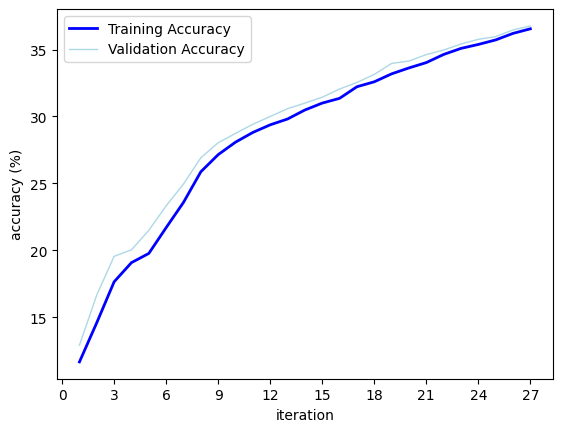

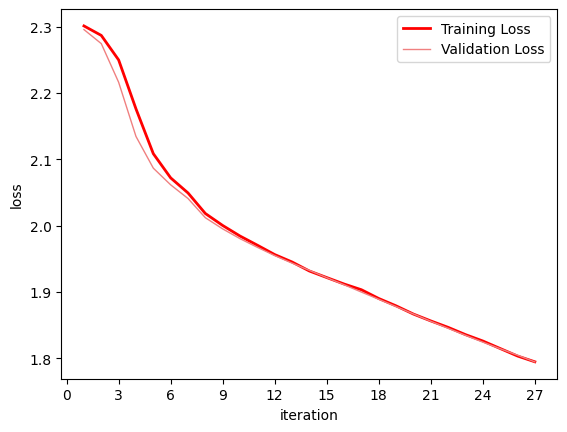

In [103]:
lenet5_trainer.plot(type="accuracy")
lenet5_trainer.plot(type="loss")

### b. Modern Hyperparameters

In [84]:
# Define LeNet5v2 Class
class LeNet5v2(nn.Module):

    def __init__(self):

        super(LeNet5v2, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)

        self.bn1 = nn.BatchNorm2d(6)

        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)

        self.bn2 = nn.BatchNorm2d(16)

        self.fc1 = nn.Linear(in_features=16*5*5, out_features=120)

        self.bn3 = nn.BatchNorm1d(120)

        self.fc2 = nn.Linear(in_features=120, out_features=84)

        self.bn4 = nn.BatchNorm1d(84)

        self.fc3 = nn.Linear(in_features=84, out_features=10)

        self.dropout = nn.Dropout(0.5)

        self.relu = nn.ReLU(inplace=True)

        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)


    def forward(self, x):

        x = self.relu(self.bn1(self.conv1(x)))

        x = self.max_pool(x)

        x = self.relu(self.bn2(self.conv2(x)))

        x = self.max_pool(x)

        x = x.view(-1, 16*5*5) # flatten
        
        x = self.dropout(self.relu(self.bn3(self.fc1(x))))

        x = self.dropout(self.relu(self.bn4(self.fc2(x))))

        x = self.fc3(x)

        return x

In [85]:
# create an instance of LeNet5v2 model

lenet5v2 = LeNet5v2()

lenet5v2 = lenet5v2.to(device)



# define the loss function and optimizer

criterion_lenet5v2 = nn.CrossEntropyLoss()

optimizer_lenet5v2 = optim.Adam(lenet5v2.parameters(), lr=0.001)



# create an instance for lenet 5 trainer

lenet5v2_trainer = Trainer(model=lenet5v2, optimizer=optimizer_lenet5v2, loss_fn=criterion_lenet5v2, dataloaders=cifar10_dataloaders_1)

In [82]:
lenet5v2_trainer.flop_analysis()

print(lenet5v2_trainer.flop_count)

print(lenet5v2_trainer.parameter_count)

683240
| name           | #elements or shape   |
|:---------------|:---------------------|
| model          | 62.5K                |
|  conv1         |  0.5K                |
|   conv1.weight |   (6, 3, 5, 5)       |
|   conv1.bias   |   (6,)               |
|  bn1           |  12                  |
|   bn1.weight   |   (6,)               |
|   bn1.bias     |   (6,)               |
|  conv2         |  2.4K                |
|   conv2.weight |   (16, 6, 5, 5)      |
|   conv2.bias   |   (16,)              |
|  bn2           |  32                  |
|   bn2.weight   |   (16,)              |
|   bn2.bias     |   (16,)              |
|  fc1           |  48.1K               |
|   fc1.weight   |   (120, 400)         |
|   fc1.bias     |   (120,)             |
|  bn3           |  0.2K                |
|   bn3.weight   |   (120,)             |
|   bn3.bias     |   (120,)             |
|  fc2           |  10.2K               |
|   fc2.weight   |   (84, 120)          |
|   fc2.bias     |   (84,) 

In [88]:
lenet5v2_trainer.train(50)

Epoch 1/50, Loss: 0.8982, Accuracy: 68.83%, Validation Loss: 0.9372, Validation Accuracy: 67.32%.
Epoch 2/50, Loss: 0.8980, Accuracy: 68.97%, Validation Loss: 0.9418, Validation Accuracy: 67.06%.
Epoch 3/50, Loss: 0.8994, Accuracy: 68.73%, Validation Loss: 0.9413, Validation Accuracy: 67.03%.
Epoch 4/50, Loss: 0.9032, Accuracy: 68.71%, Validation Loss: 0.9422, Validation Accuracy: 67.21%.
Epoch 5/50, Loss: 0.9053, Accuracy: 68.68%, Validation Loss: 0.9369, Validation Accuracy: 67.23%.
Epoch 6/50, Loss: 0.9048, Accuracy: 68.61%, Validation Loss: 0.9357, Validation Accuracy: 67.38%.
Epoch 7/50, Loss: 0.9017, Accuracy: 68.61%, Validation Loss: 0.9338, Validation Accuracy: 67.46%.
Epoch 8/50, Loss: 0.8931, Accuracy: 69.25%, Validation Loss: 0.9374, Validation Accuracy: 67.14%.
Epoch 9/50, Loss: 0.9002, Accuracy: 68.86%, Validation Loss: 0.9547, Validation Accuracy: 66.74%.
Epoch 10/50, Loss: 0.8920, Accuracy: 68.97%, Validation Loss: 0.9304, Validation Accuracy: 67.76%.
Epoch 11/50, Loss: 

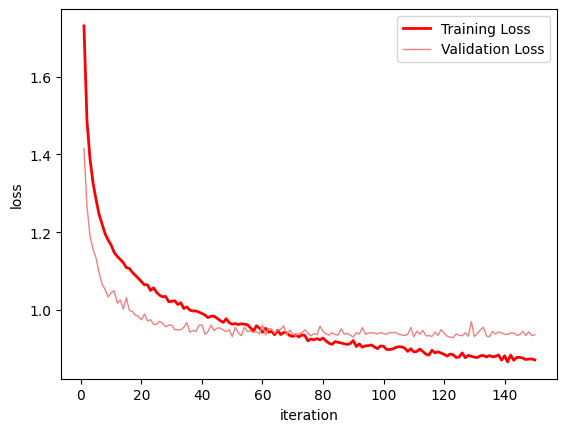

In [112]:
lenet5v2_trainer.plot("loss")

In [108]:
# Define LeNet5v3 Class
class LeNet5v3(nn.Module):

    def __init__(self):

        super(LeNet5v3, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=18, kernel_size=5, stride=1, padding=0)

        self.bn1 = nn.BatchNorm2d(18)

        self.conv2 = nn.Conv2d(in_channels=18, out_channels=48, kernel_size=5, stride=1, padding=0)

        self.bn2 = nn.BatchNorm2d(48)

        self.fc1 = nn.Linear(in_features=48*5*5, out_features=360)

        self.bn3 = nn.BatchNorm1d(360)

        self.fc2 = nn.Linear(in_features=360, out_features=252)

        self.bn4 = nn.BatchNorm1d(252)

        self.fc3 = nn.Linear(in_features=252, out_features=10)

        self.dropout = nn.Dropout(0.5)

        self.relu = nn.ReLU(inplace=True)

        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)


    def forward(self, x):

        x = self.relu(self.bn1(self.conv1(x)))

        x = self.max_pool(x)

        x = self.relu(self.bn2(self.conv2(x)))

        x = self.max_pool(x)

        x = x.view(-1, 48*5*5) # flatten
        
        x = self.dropout(self.relu(self.bn3(self.fc1(x))))

        x = self.dropout(self.relu(self.bn4(self.fc2(x))))

        x = self.fc3(x)

        return x

In [109]:
# create an instance of LeNet5v2 model

lenet5v3 = LeNet5v3()

lenet5v3 = lenet5v3.to(device)



# define the loss function and optimizer

criterion_lenet5v3 = nn.CrossEntropyLoss()

optimizer_lenet5v3 = optim.Adam(lenet5v3.parameters(), lr=0.001)



# create an instance for lenet 5 trainer

lenet5v3_trainer = Trainer(model=lenet5v3, optimizer=optimizer_lenet5v3, loss_fn=criterion_lenet5v3, dataloaders=cifar10_dataloaders_1)

In [110]:
lenet5v3_trainer.train(150)

Epoch 1/150, Loss: 1.4881, Accuracy: 46.26%, Validation Loss: 1.1716, Validation Accuracy: 57.91%.
Epoch 2/150, Loss: 1.1923, Accuracy: 57.67%, Validation Loss: 1.0334, Validation Accuracy: 63.59%.
Epoch 3/150, Loss: 1.0558, Accuracy: 62.92%, Validation Loss: 0.9512, Validation Accuracy: 66.22%.
Epoch 4/150, Loss: 0.9706, Accuracy: 66.23%, Validation Loss: 0.9029, Validation Accuracy: 68.04%.
Epoch 5/150, Loss: 0.9059, Accuracy: 68.39%, Validation Loss: 0.8373, Validation Accuracy: 70.51%.
Epoch 6/150, Loss: 0.8476, Accuracy: 70.50%, Validation Loss: 0.8106, Validation Accuracy: 71.50%.
Epoch 7/150, Loss: 0.8043, Accuracy: 71.89%, Validation Loss: 0.7964, Validation Accuracy: 72.14%.
Epoch 8/150, Loss: 0.7723, Accuracy: 73.24%, Validation Loss: 0.8068, Validation Accuracy: 71.16%.
Epoch 9/150, Loss: 0.7300, Accuracy: 74.53%, Validation Loss: 0.7783, Validation Accuracy: 72.52%.
Epoch 10/150, Loss: 0.6979, Accuracy: 75.69%, Validation Loss: 0.7870, Validation Accuracy: 72.68%.
Epoch 11/

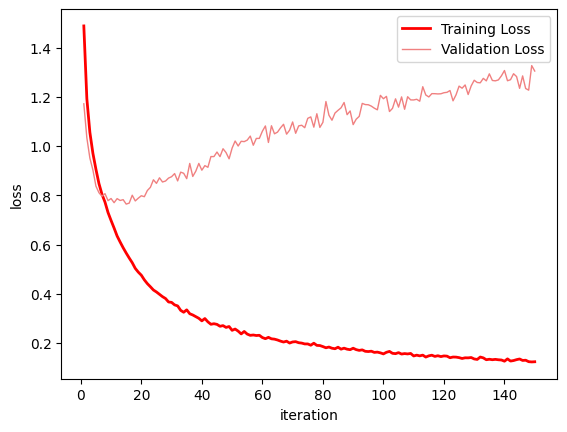

In [113]:
lenet5v3_trainer.plot("loss")

# 4. ResNet-18 (from scratch)

In [17]:
# define the basic block, this is the building block of any ResNet

# it consists of 2 convolution layer, with batchnorm applied to the outputs.

# relu is used for activation for both outputs,

# however a skip connection is added to the second layer before passed into relu activation

class BasicBlock(nn.Module):

    def __init__(self, in_channels, out_channels, stride=1):

        # calling the init method of nn.Module

        super(BasicBlock, self).__init__()

        # first conv layer with any stride

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)

        self.bn1 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)

        # second conv layer with fixed stride of 1

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)

        self.bn2 = nn.BatchNorm2d(out_channels)

        # the skip connection if stride is 1 or input=output channels

        self.shortcut = nn.Sequential()



        # if the stride > 1 or the number of input channels differs from output channel,

        # input and output channels will be different either way

        # the skip connection needs to adjust in size

        if stride != 1 or in_channels != out_channels:

            self.shortcut = nn.Sequential(

                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),

                nn.BatchNorm2d(out_channels)

            )



    # forwar pass for the Basic Block

    def forward(self, x):

        out = self.conv1(x)

        out = self.bn1(out)

        out = self.relu(out)

        out = self.conv2(out)

        out = self.bn2(out)

        out += self.shortcut(x)

        out = self.relu(out)

        return out

In [23]:
# define the Resnet18 class

class ResNet18(nn.Module):

    def __init__(self, num_classes=10):

        super(ResNet18, self).__init__()

        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

        self.bn1 = nn.BatchNorm2d(64)

        self.relu = nn.ReLU(inplace=True)

        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)



        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)

        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)

        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)

        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)



        self.avgpool = nn.AdaptiveAvgPool2d((1,1))

        self.fc = nn.Linear(512, num_classes)



    # this will output the skip connection blocks with the same output channels,

    # for Resnet18, the output channels are 64, 128, 256, 512

    # with each block made up of 2 BasicBlocks

    def _make_layer(self, block, out_channels, n_blocks, stride):

        # lists all the input strides for each BasicBlock

        strides = [stride] + [1]*(n_blocks - 1)

        # empyt container layer for the block

        layers = []

        # loop over the strides. The number of strides is the same as the number of BasicBlocks (in this case 2)

        for stride in strides:

            # append the BasicBlock based on the stride

            layers.append(block(self.in_channels, out_channels, stride))

            # adjust the output channel for the next BasicBlock

            self.in_channels = out_channels

        return nn.Sequential(*layers)



    # forward pass for Resnet18

    def forward(self, x):

        out = self.conv1(x)

        out = self.bn1(out)

        out = self.relu(out)

        out = self.maxpool(out)



        out = self.layer1(out)

        out = self.layer2(out)

        out = self.layer3(out)

        out = self.layer4(out)



        out = self.avgpool(out)

        # transform to single vector to be passed into the fully connected layer with linear activation

        out = out.view(out.size(0), -1)

        out = self.fc(out)

        return out



In [24]:
resnet18 = ResNet18()

resnet18 = resnet18.to(device)

resnet18_criterion = nn.CrossEntropyLoss()

resnet18_optimizer = optim.SGD(resnet18.parameters(), lr=0.001)

resnet18_trainer = Trainer(model=resnet18, optimizer=resnet18_optimizer, loss_fn=resnet18_criterion, dataloaders=cifar10_dataloaders_1, per_batch=False)

In [26]:
resnet18_trainer.train(epoch = 20)

Epoch 1/20, Loss: 1.3329, Accuracy: 53.64%, Validation Loss: 1.4357, Validation Accuracy: 47.90%.
Epoch 2/20, Loss: 1.2919, Accuracy: 55.27%, Validation Loss: 1.4096, Validation Accuracy: 49.07%.
Epoch 3/20, Loss: 1.2526, Accuracy: 56.90%, Validation Loss: 1.3929, Validation Accuracy: 49.70%.
Epoch 4/20, Loss: 1.2166, Accuracy: 58.28%, Validation Loss: 1.3670, Validation Accuracy: 50.65%.
Epoch 5/20, Loss: 1.1825, Accuracy: 59.51%, Validation Loss: 1.3515, Validation Accuracy: 50.87%.
Epoch 6/20, Loss: 1.1486, Accuracy: 60.76%, Validation Loss: 1.3384, Validation Accuracy: 51.41%.
Epoch 7/20, Loss: 1.1135, Accuracy: 62.07%, Validation Loss: 1.3157, Validation Accuracy: 52.17%.
Epoch 8/20, Loss: 1.0813, Accuracy: 63.38%, Validation Loss: 1.3074, Validation Accuracy: 52.74%.
Epoch 9/20, Loss: 1.0522, Accuracy: 64.49%, Validation Loss: 1.3082, Validation Accuracy: 52.73%.
Epoch 10/20, Loss: 1.0220, Accuracy: 65.86%, Validation Loss: 1.2786, Validation Accuracy: 54.20%.
Epoch 11/20, Loss: 

In [27]:
resnet18_trainer.flop_analysis()

print(resnet18_trainer.flop_count)

print(resnet18_trainer.parameter_count)

140594176
| name                 | #elements or shape   |
|:---------------------|:---------------------|
| model                | 11.2M                |
|  conv1               |  1.7K                |
|   conv1.weight       |   (64, 3, 3, 3)      |
|  bn1                 |  0.1K                |
|   bn1.weight         |   (64,)              |
|   bn1.bias           |   (64,)              |
|  layer1              |  0.1M                |
|   layer1.0           |   74.0K              |
|    layer1.0.conv1    |    36.9K             |
|    layer1.0.bn1      |    0.1K              |
|    layer1.0.conv2    |    36.9K             |
|    layer1.0.bn2      |    0.1K              |
|   layer1.1           |   74.0K              |
|    layer1.1.conv1    |    36.9K             |
|    layer1.1.bn1      |    0.1K              |
|    layer1.1.conv2    |    36.9K             |
|    layer1.1.bn2      |    0.1K              |
|  layer2              |  0.5M                |
|   layer2.0           |   0.2

In [30]:
accuracy, loss = resnet18_trainer.test()
print("test accuracy: ", accuracy)
print("test loss: ", loss)

test accuracy:  56.65
test loss:  1.205367386341095


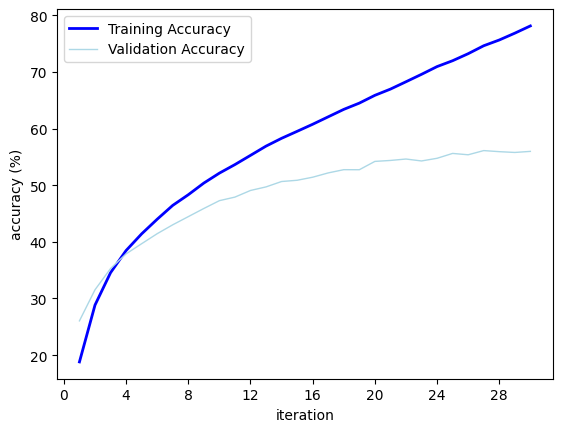

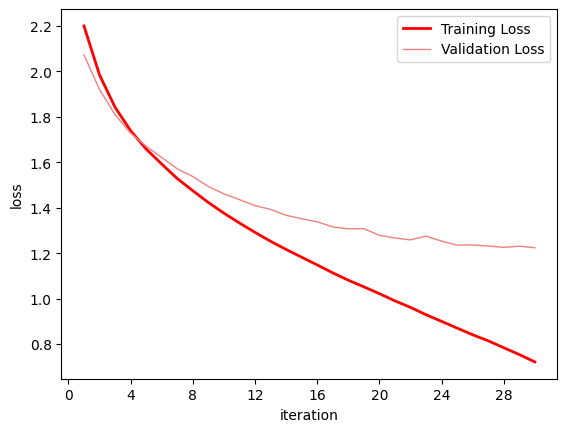

In [31]:
resnet18_trainer.plot("accuracy")
resnet18_trainer.plot("loss")

### b. Tuning

In [32]:
class ResNet18v2(nn.Module):

    def __init__(self, num_classes=10):

        super(ResNet18v2, self).__init__()

        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

        self.bn1 = nn.BatchNorm2d(64)

        self.relu = nn.ReLU(inplace=True)

        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.dropout = nn.Dropout(0.85)



        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)

        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)

        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)

        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)



        self.avgpool = nn.AdaptiveAvgPool2d((1,1))

        self.fc = nn.Linear(512, num_classes)



    # this will output the skip connection blocks with the same output channels,

    # for Resnet18, the output channels are 64, 128, 256, 512

    # with each block made up of 2 BasicBlocks

    def _make_layer(self, block, out_channels, n_blocks, stride):

        # lists all the input strides for each BasicBlock

        strides = [stride] + [1]*(n_blocks - 1)

        # empyt container layer for the block

        layers = []

        # loop over the strides. The number of strides is the same as the number of BasicBlocks (in this case 2)

        for stride in strides:

            # append the BasicBlock based on the stride

            layers.append(block(self.in_channels, out_channels, stride))

            # adjust the output channel for the next BasicBlock

            self.in_channels = out_channels

        return nn.Sequential(*layers)



    # forward pass for Resnet18

    def forward(self, x):

        out = self.conv1(x)

        out = self.bn1(out)

        out = self.relu(out)

        out = self.maxpool(out)



        out = self.layer1(out)

        out = self.layer2(out)

        out = self.layer3(out)

        out = self.layer4(out)



        out = self.avgpool(out)

        # transform to single vector to be passed into the fully connected layer with linear activation

        out = out.view(out.size(0), -1)

        out = self.dropout(out)

        out = self.fc(out)

        return out

In [38]:
resnet18v2 = ResNet18v2()

resnet18v2 = resnet18v2.to(device)

resnet18v2_criterion = nn.CrossEntropyLoss()

resnet18v2_optimizer = optim.Adam(resnet18v2.parameters(), lr=0.001, weight_decay = 0.0001)

resnet18v2_trainer = Trainer(model=resnet18v2, optimizer=resnet18v2_optimizer, loss_fn=resnet18v2_criterion, dataloaders=cifar10_dataloaders_augmented, per_batch=False)

In [39]:
resnet18v2_trainer.train(epoch=20)

Epoch 1/20, Loss: 1.6810, Accuracy: 40.74%, Validation Loss: 1.3674, Validation Accuracy: 52.35%.
Epoch 2/20, Loss: 1.1027, Accuracy: 61.73%, Validation Loss: 1.0926, Validation Accuracy: 62.40%.
Epoch 3/20, Loss: 0.8753, Accuracy: 70.49%, Validation Loss: 0.9749, Validation Accuracy: 67.51%.
Epoch 4/20, Loss: 0.7089, Accuracy: 76.26%, Validation Loss: 0.8598, Validation Accuracy: 71.45%.
Epoch 5/20, Loss: 0.5989, Accuracy: 80.16%, Validation Loss: 0.9193, Validation Accuracy: 71.17%.
Epoch 6/20, Loss: 0.4946, Accuracy: 83.86%, Validation Loss: 0.7685, Validation Accuracy: 74.99%.
Epoch 7/20, Loss: 0.4178, Accuracy: 86.28%, Validation Loss: 1.1660, Validation Accuracy: 68.51%.
Epoch 8/20, Loss: 0.3690, Accuracy: 87.92%, Validation Loss: 1.0379, Validation Accuracy: 72.13%.
Epoch 9/20, Loss: 0.2997, Accuracy: 90.55%, Validation Loss: 0.8041, Validation Accuracy: 76.61%.
Epoch 10/20, Loss: 0.2379, Accuracy: 92.31%, Validation Loss: 0.8024, Validation Accuracy: 77.70%.
Epoch 11/20, Loss: 

In [40]:
accuracy, loss = resnet18v2_trainer.test()
print("test accuracy: ", accuracy)
print("test loss: ", loss)

test accuracy:  78.48
test loss:  1.0152119278907776


In [41]:
resnet18v2_trainer.flop_analysis()

print(resnet18v2_trainer.flop_count)

print(resnet18v2_trainer.parameter_count)

140594176
| name                 | #elements or shape   |
|:---------------------|:---------------------|
| model                | 11.2M                |
|  conv1               |  1.7K                |
|   conv1.weight       |   (64, 3, 3, 3)      |
|  bn1                 |  0.1K                |
|   bn1.weight         |   (64,)              |
|   bn1.bias           |   (64,)              |
|  layer1              |  0.1M                |
|   layer1.0           |   74.0K              |
|    layer1.0.conv1    |    36.9K             |
|    layer1.0.bn1      |    0.1K              |
|    layer1.0.conv2    |    36.9K             |
|    layer1.0.bn2      |    0.1K              |
|   layer1.1           |   74.0K              |
|    layer1.1.conv1    |    36.9K             |
|    layer1.1.bn1      |    0.1K              |
|    layer1.1.conv2    |    36.9K             |
|    layer1.1.bn2      |    0.1K              |
|  layer2              |  0.5M                |
|   layer2.0           |   0.2

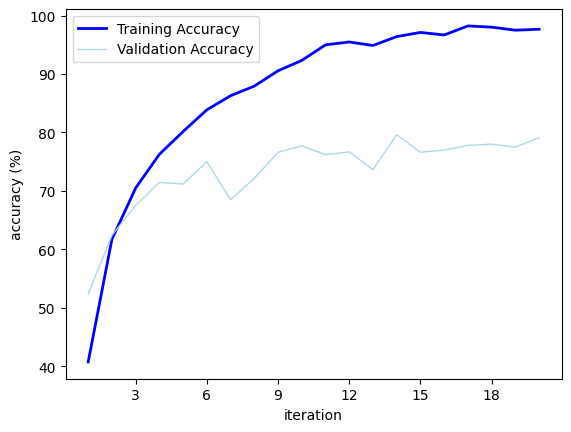

In [42]:
resnet18v2_trainer.plot("accuracy")

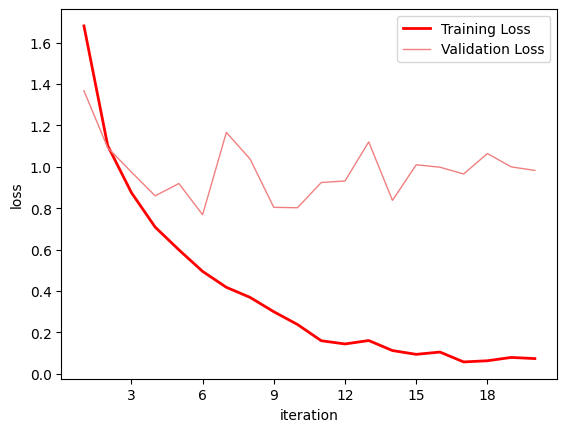

In [44]:
resnet18v2_trainer.plot("loss")

# 5. Plain ResNet-18 (from scratch)

This is a ResNet-18 implementation without skip connections

In [45]:


# define the basic block, this is the building block of Plain ResNet

# it consists of 2 convolution layer, with batchnorm applied to the outputs.

# relu is used for activation for both outputs,

# however no skip connection is added

class BasicBlockPlain(nn.Module):

    def __init__(self, in_channels, out_channels, stride=1):

        # calling the init method of nn.Module

        super(BasicBlockPlain, self).__init__()

        # first conv layer with any stride

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)

        self.bn1 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)

        # second conv layer with fixed stride of 1

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)

        self.bn2 = nn.BatchNorm2d(out_channels)



    # forward pass for the plain Basic Block

    def forward(self, x):

        out = self.conv1(x)

        out = self.bn1(out)

        out = self.relu(out)

        out = self.conv2(out)

        out = self.bn2(out)

        out = self.relu(out)

        return out

In [46]:
# define the Plain Resnet18 class

class PlainResNet18(nn.Module):

    def __init__(self, num_classes=10):

        super(PlainResNet18, self).__init__()

        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

        self.bn1 = nn.BatchNorm2d(64)

        self.relu = nn.ReLU(inplace=True)

        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)



        self.layer1 = self._make_layer(BasicBlockPlain, 64, 2, stride=1)

        self.layer2 = self._make_layer(BasicBlockPlain, 128, 2, stride=2)

        self.layer3 = self._make_layer(BasicBlockPlain, 256, 2, stride=2)

        self.layer4 = self._make_layer(BasicBlockPlain, 512, 2, stride=2)



        self.avgpool = nn.AdaptiveAvgPool2d((1,1))

        self.fc = nn.Linear(512, num_classes)



    # this will output the skip connection blocks with the same output channels,

    # for Resnet18, the output channels are 64, 128, 256, 512

    # with each block made up of 2 BasicBlocks

    def _make_layer(self, block, out_channels, n_blocks, stride):

        # lists all the input strides for each BasicBlock

        strides = [stride] + [1]*(n_blocks - 1)

        # empyt container layer for the block

        layers = []

        # loop over the strides. The number of strides is the same as the number of BasicBlocks (in this case 2)

        for stride in strides:

            # append the BasicBlock based on the stride

            layers.append(block(self.in_channels, out_channels, stride))

            # adjust the output channel for the next BasicBlock

            self.in_channels = out_channels

        return nn.Sequential(*layers)



    # forward pass for Resnet18

    def forward(self, x):

        out = self.conv1(x)

        out = self.bn1(out)

        out = self.relu(out)

        out = self.maxpool(out)



        out = self.layer1(out)

        out = self.layer2(out)

        out = self.layer3(out)

        out = self.layer4(out)



        out = self.avgpool(out)

        # transform to single vector to be passed into the fully connected layer with linear activation

        out = out.view(out.size(0), -1)

        out = self.fc(out)

        return out



In [51]:
plain_resnet18 = PlainResNet18()

plain_resnet18 = plain_resnet18.to(device)

plain_resnet18_criterion = nn.CrossEntropyLoss()

plain_resnet18_optimizer = optim.Adam(plain_resnet18.parameters(), lr=0.001, weight_decay = 0.0001)

plain_resnet18_trainer = Trainer(model=plain_resnet18, optimizer=plain_resnet18_optimizer, loss_fn=plain_resnet18_criterion, dataloaders=cifar10_dataloaders_augmented)

In [52]:
plain_resnet18_trainer.train(epoch=20)

Epoch 1/20, Loss: 1.5116, Accuracy: 43.92%, Validation Loss: 1.4985, Validation Accuracy: 49.17%.
Epoch 2/20, Loss: 1.0972, Accuracy: 60.72%, Validation Loss: 1.1948, Validation Accuracy: 58.85%.
Epoch 3/20, Loss: 0.9001, Accuracy: 68.06%, Validation Loss: 1.0546, Validation Accuracy: 62.75%.
Epoch 4/20, Loss: 0.7791, Accuracy: 72.60%, Validation Loss: 0.8486, Validation Accuracy: 70.63%.
Epoch 5/20, Loss: 0.6685, Accuracy: 76.78%, Validation Loss: 0.8603, Validation Accuracy: 70.81%.
Epoch 6/20, Loss: 0.5652, Accuracy: 80.53%, Validation Loss: 0.8452, Validation Accuracy: 72.60%.
Epoch 7/20, Loss: 0.4991, Accuracy: 82.93%, Validation Loss: 0.8265, Validation Accuracy: 72.99%.
Epoch 8/20, Loss: 0.4466, Accuracy: 84.55%, Validation Loss: 0.8098, Validation Accuracy: 74.33%.
Epoch 9/20, Loss: 0.3828, Accuracy: 86.81%, Validation Loss: 0.8806, Validation Accuracy: 72.67%.
Epoch 10/20, Loss: 0.3250, Accuracy: 89.00%, Validation Loss: 0.8784, Validation Accuracy: 74.41%.
Epoch 11/20, Loss: 

In [55]:
accuracy, loss = plain_resnet18_trainer.test()

print("test accuracy: ", accuracy)
print("test loss: ", loss)

test accuracy:  77.09
test loss:  0.9034374922513961


In [53]:

plain_resnet18_trainer.flop_analysis()

print(plain_resnet18_trainer.flop_count)

print(plain_resnet18_trainer.parameter_count)

138992640
| name              | #elements or shape   |
|:------------------|:---------------------|
| model             | 11.0M                |
|  conv1            |  1.7K                |
|   conv1.weight    |   (64, 3, 3, 3)      |
|  bn1              |  0.1K                |
|   bn1.weight      |   (64,)              |
|   bn1.bias        |   (64,)              |
|  layer1           |  0.1M                |
|   layer1.0        |   74.0K              |
|    layer1.0.conv1 |    36.9K             |
|    layer1.0.bn1   |    0.1K              |
|    layer1.0.conv2 |    36.9K             |
|    layer1.0.bn2   |    0.1K              |
|   layer1.1        |   74.0K              |
|    layer1.1.conv1 |    36.9K             |
|    layer1.1.bn1   |    0.1K              |
|    layer1.1.conv2 |    36.9K             |
|    layer1.1.bn2   |    0.1K              |
|  layer2           |  0.5M                |
|   layer2.0        |   0.2M               |
|    layer2.0.conv1 |    73.7K             |


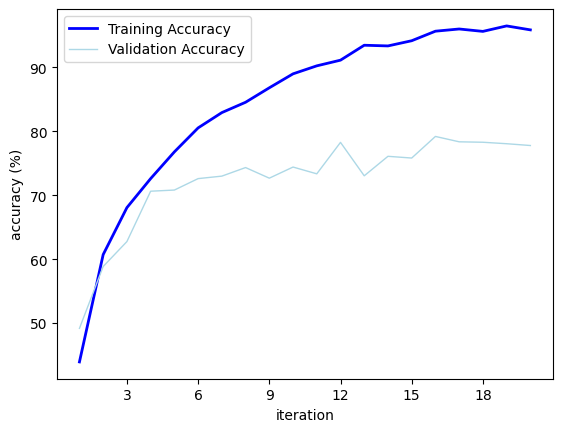

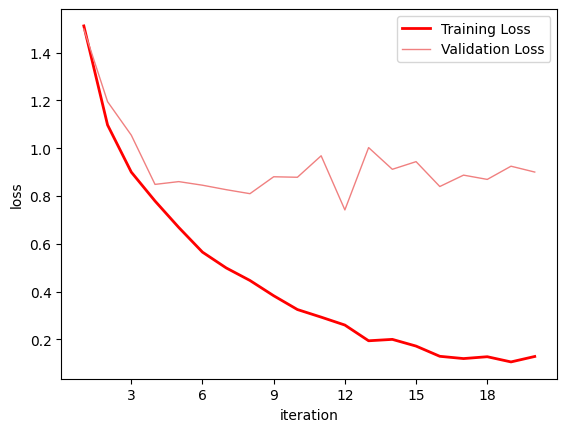

In [56]:
plain_resnet18_trainer.plot("accuracy")
plain_resnet18_trainer.plot("loss")

# 6. AlexNet (fine-tune)

### Fine Tune to Thermal Dogs and People Dataset

In [ ]:
# load the AlexNet model and modify the final layer to match the number of multi-label classes in Thermal Dogs and People Dataset (2)

alexnet = models.alexnet(pretrained=True)

alexnet.classifier[6] = nn.Linear(4096, 2)

alexnet = alexnet.to(device)



# define loss function and optimizer

alixnet_criterion = nn.BCEWithLogitsLoss() # sutiable for multilabel classification

alexnet_optimizer = optim.Adam(alexnet.parameters(), lr=0.001)

C:\Users\putra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\putra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
alexnet_trainer = Trainer(alexnet, alexnet_optimizer, alixnet_criterion, thermal_dataloaders, False, 2)

alexnet_trainer.flop_analysis()

print(alexnet_trainer.flop_count)

print(alexnet_trainer.parameter_count)

Unsupported operator aten::max_pool2d encountered 3 time(s)


710109888
| name                   | #elements or shape   |
|:-----------------------|:---------------------|
| model                  | 57.0M                |
|  features              |  2.5M                |
|   features.0           |   23.3K              |
|    features.0.weight   |    (64, 3, 11, 11)   |
|    features.0.bias     |    (64,)             |
|   features.3           |   0.3M               |
|    features.3.weight   |    (192, 64, 5, 5)   |
|    features.3.bias     |    (192,)            |
|   features.6           |   0.7M               |
|    features.6.weight   |    (384, 192, 3, 3)  |
|    features.6.bias     |    (384,)            |
|   features.8           |   0.9M               |
|    features.8.weight   |    (256, 384, 3, 3)  |
|    features.8.bias     |    (256,)            |
|   features.10          |   0.6M               |
|    features.10.weight  |    (256, 256, 3, 3)  |
|    features.10.bias    |    (256,)            |
|  classifier            |  54.5M       

# 7. Mobilenet (fine-tune)

### a. Fine Tune to CIFAR 10

In [ ]:
# load the MobileNet model and modify the final layer to match the number of classes in CIFAR-10 (10)

mobilenetV2 = models.mobilenet_v2(pretrained=True)

mobilenetV2.classifier[1] = nn.Linear(mobilenetV2.classifier[1].in_features, 10)

mobilenetV2 = mobilenetV2.to(device)



# define loss function and optimizer

mobilenetV2_criterion = nn.CrossEntropyLoss()

mobilenetV2_optimizer = optim.Adam(alexnet.parameters(), lr=0.001)

In [ ]:
mobilenetV2_trainer = Trainer(mobilenetV2, mobilenetV2_optimizer, mobilenetV2_criterion, thermal_dataloaders, False, 2)

mobilenetV2_trainer.flop_analysis()

print(mobilenetV2_trainer.flop_count)

print(mobilenetV2_trainer.parameter_count)

Unsupported operator aten::add_ encountered 52 time(s)
Unsupported operator aten::hardtanh_ encountered 35 time(s)
Unsupported operator aten::add encountered 10 time(s)


332950112
| name                   | #elements or shape   |
|:-----------------------|:---------------------|
| model                  | 2.2M                 |
|  features              |  2.2M                |
|   features.0           |   0.9K               |
|    features.0.0        |    0.9K              |
|    features.0.1        |    64                |
|   features.1           |   0.9K               |
|    features.1.conv     |    0.9K              |
|   features.2           |   5.1K               |
|    features.2.conv     |    5.1K              |
|   features.3           |   8.8K               |
|    features.3.conv     |    8.8K              |
|   features.4           |   10.0K              |
|    features.4.conv     |    10.0K             |
|   features.5           |   14.8K              |
|    features.5.conv     |    14.8K             |
|   features.6           |   14.8K              |
|    features.6.conv     |    14.8K             |
|   features.7           |   21.1K      

### b. Fine Tune to Thermal Dogs and People Dataset

In [ ]:
# load the MobileNet model and modify the final layer to match the number of multi-label classes in Thermal Dogs and People Dataset (2)

mobilenetV2 = models.mobilenet_v2(pretrained=True)

mobilenetV2.classifier[1] = nn.Linear(mobilenetV2.classifier[1].in_features, 2)

mobilenetV2 = mobilenetV2.to(device)



# define loss function and optimizer

mobilenetV2_criterion = nn.BCEWithLogitsLoss()

mobilenetV2_optimizer = optim.Adam(alexnet.parameters(), lr=0.001)

In [ ]:
mobilenetV2_trainer = Trainer(mobilenetV2, mobilenetV2_optimizer, mobilenetV2_criterion, thermal_dataloaders, False, 2)

mobilenetV2_trainer.flop_analysis()

print(mobilenetV2_trainer.flop_count)

print(mobilenetV2_trainer.parameter_count)

Unsupported operator aten::add_ encountered 52 time(s)
Unsupported operator aten::hardtanh_ encountered 35 time(s)
Unsupported operator aten::add encountered 10 time(s)


332950112
| name                   | #elements or shape   |
|:-----------------------|:---------------------|
| model                  | 2.2M                 |
|  features              |  2.2M                |
|   features.0           |   0.9K               |
|    features.0.0        |    0.9K              |
|    features.0.1        |    64                |
|   features.1           |   0.9K               |
|    features.1.conv     |    0.9K              |
|   features.2           |   5.1K               |
|    features.2.conv     |    5.1K              |
|   features.3           |   8.8K               |
|    features.3.conv     |    8.8K              |
|   features.4           |   10.0K              |
|    features.4.conv     |    10.0K             |
|   features.5           |   14.8K              |
|    features.5.conv     |    14.8K             |
|   features.6           |   14.8K              |
|    features.6.conv     |    14.8K             |
|   features.7           |   21.1K      

# 8. ViT (fine-tune)

### a. Fine Tune to CIFAR-10 Dataset

It's Already trained on CIFAR-10

In [ ]:
# load the ViT model and modify the final layer to match the number of classes in CIFAR-10 (10)

vit = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")

vit.classifier = nn.Linear(vit.classifier.in_features, 2) # Modify the final layer for 2 labels (dog and person)

vit = vit.to(device)



# define loss function and optimizer

vit_criterion = nn.CrossEntropyLoss()

vit_optimizer = optim.Adam(alexnet.parameters(), lr=0.001)

In [ ]:
vit_trainer = Trainer(vit, vit_optimizer, vit_criterion, thermal_dataloaders_vit, False, 2)

# vit_trainer.train()

vit_trainer.flop_analysis()

print(vit_trainer.flop_count)

print(vit_trainer.parameter_count)

torch.Size([3, 224, 224])


Unsupported operator aten::add encountered 25 time(s)
Unsupported operator aten::scaled_dot_product_attention encountered 12 time(s)
Unsupported operator aten::gelu encountered 12 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by direct calls to .forward() or via other python methods. In the latter case they will have zeros for statistics, though their statistics will still contribute to their parent calling module.
vit.encoder.layer.0.attention.attention.dropout, vit.encoder.layer.1.attention.attention.dropout, vit.encoder.layer.10.attention.attention.dropout, vit.encoder.layer.11.attention.attention.dropout, vit.encoder.layer.2.attention.attention.dropout, vit.encoder.layer.3.attention.attention.dropout, vit.encoder.layer.4.attention.attention.dropout, vit.encoder.layer.5.attention.attention.dropout, vit.encoder.layer.6.attention.attention.dropout, vit.encoder.layer.7.attention.attention.dropout

16866646272
| name                                  | #elements or shape   |
|:--------------------------------------|:---------------------|
| model                                 | 85.8M                |
|  vit                                  |  85.8M               |
|   vit.embeddings                      |   0.7M               |
|    vit.embeddings.cls_token           |    (1, 1, 768)       |
|    vit.embeddings.position_embeddings |    (1, 197, 768)     |
|    vit.embeddings.patch_embeddings    |    0.6M              |
|   vit.encoder                         |   85.1M              |
|    vit.encoder.layer                  |    85.1M             |
|   vit.layernorm                       |   1.5K               |
|    vit.layernorm.weight               |    (768,)            |
|    vit.layernorm.bias                 |    (768,)            |
|  classifier                           |  1.5K                |
|   classifier.weight                   |   (2, 768)           |
|   classifie

### b. Fine Tune to Thermal Dogs and People Dataset

In [ ]:
# load the ViT model and modify the final layer to match the number of multi-label classes in Thermal Dogs and People Dataset (2)

vit = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")

vit.classifier = nn.Linear(vit.classifier.in_features, 2) # Modify the final layer for 2 labels (dog and person)

vit = vit.to(device)



# define loss function and optimizer

vit_criterion = nn.BCEWithLogitsLoss()

vit_optimizer = optim.Adam(alexnet.parameters(), lr=0.001)

In [ ]:
vit_trainer = Trainer(vit, vit_optimizer, vit_criterion, thermal_dataloaders_vit, False, 2)

vit_trainer.flop_analysis()

print(vit_trainer.flop_count)

print(vit_trainer.parameter_count)

Unsupported operator aten::add encountered 25 time(s)
Unsupported operator aten::scaled_dot_product_attention encountered 12 time(s)
Unsupported operator aten::gelu encountered 12 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by direct calls to .forward() or via other python methods. In the latter case they will have zeros for statistics, though their statistics will still contribute to their parent calling module.
vit.encoder.layer.0.attention.attention.dropout, vit.encoder.layer.1.attention.attention.dropout, vit.encoder.layer.10.attention.attention.dropout, vit.encoder.layer.11.attention.attention.dropout, vit.encoder.layer.2.attention.attention.dropout, vit.encoder.layer.3.attention.attention.dropout, vit.encoder.layer.4.attention.attention.dropout, vit.encoder.layer.5.attention.attention.dropout, vit.encoder.layer.6.attention.attention.dropout, vit.encoder.layer.7.attention.attention.dropout

16866646272
| name                                  | #elements or shape   |
|:--------------------------------------|:---------------------|
| model                                 | 85.8M                |
|  vit                                  |  85.8M               |
|   vit.embeddings                      |   0.7M               |
|    vit.embeddings.cls_token           |    (1, 1, 768)       |
|    vit.embeddings.position_embeddings |    (1, 197, 768)     |
|    vit.embeddings.patch_embeddings    |    0.6M              |
|   vit.encoder                         |   85.1M              |
|    vit.encoder.layer                  |    85.1M             |
|   vit.layernorm                       |   1.5K               |
|    vit.layernorm.weight               |    (768,)            |
|    vit.layernorm.bias                 |    (768,)            |
|  classifier                           |  1.5K                |
|   classifier.weight                   |   (2, 768)           |
|   classifie